In [1]:
import numpy as np
import cv2
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import dlib
from tensorflow import keras
from keras.preprocessing import image

## Pre-Processing Image

In [2]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

In [3]:
# fungsi untuk crop bagian hidung

def create_box_nose(img, points):
    bbox = cv2.boundingRect(points)
    x, y, w, h = bbox
    imgCrop = img[y-5:y+h+5, x-5:x+w+5]
    imgCrop = cv2.resize(imgCrop, (200, 200))
    return imgCrop

In [4]:
# fungsi untuk crop bagian pipi

def create_box_cheek(img, points):
    bbox = cv2.boundingRect(points)
    x, y, w, h = bbox
    imgCrop = img[y:y+h, x:x+w]
    imgCrop = cv2.resize(imgCrop, (200, 200))
    return imgCrop

In [5]:
# anggap ini image yang diinput oleh user

base_dir = 'image-test/t15.jpg'

## Load Model 1 (Komedo / Normal)

In [6]:
comedo_model = keras.models.load_model('model/ausion_project/comedo-model.h5')
comedo_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 6, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 2304)              0

## Load Model 2 (Bopeng / Jerawat / Normal)

In [7]:
acpock_model = keras.models.load_model('model/ausion_project/acpock-model.h5')
acpock_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 50, 50, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 25, 25, 32)        4640      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 12, 12, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 6, 6, 64)          18496     
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 3, 3, 64)        

## Making Prediction

### Predict Model 1

In [8]:
img = cv2.imread(base_dir)
img_original = img.copy
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = detector(img_gray)

for face in faces:
    x1, y1 = face.left(), face.top()
    x2, y2 = face.right(), face.bottom()
    img_original = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    landmarks = predictor(img_gray, face)
    myPoints = []
    for n in range(68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        myPoints.append([x, y])
    
    myPoints = np.array(myPoints)
    img_nose = create_box_nose(img, myPoints[27:36])
    cv2.imwrite('test-predict/test1.jpg', img_nose)

Normal


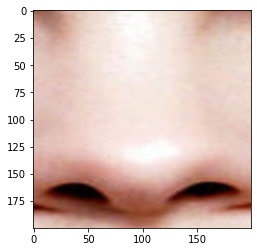

In [9]:
path = 'test-predict/test1.jpg'

img_pred = image.load_img(path, target_size=(200, 200))
imgplot = plt.imshow(img_pred)
x = image.img_to_array(img_pred)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
comedo_predict = comedo_model.predict(images, batch_size=10)

if comedo_predict[0] < 0.5:
    print("Komedo")
else:
    print("Normal")

### Predict Model 2

In [10]:
img = cv2.imread(base_dir)
img_original = img.copy
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = detector(img_gray)

for face in faces:
    x1, y1 = face.left(), face.top()
    x2, y2 = face.right(), face.bottom()
    # img_original = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    landmarks = predictor(img_gray, face)
    myPoints = []
    for n in range(68):
        x = landmarks.part(n).x
        y = landmarks.part(n).y
        myPoints.append([x, y])
    
    myPoints = np.array(myPoints)
    img_cheek_right = create_box_cheek(img, myPoints[1:7])
    img_cheek_left = create_box_cheek(img, myPoints[10:16])
    img_cheek = np.concatenate((img_cheek_right, img_cheek_left), axis=1)
    cv2.imwrite('test-predict/test2.jpg', img_cheek)

Jerawat


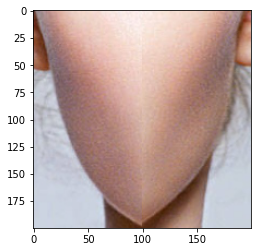

In [11]:
path = 'test-predict/test2.jpg'

img_pred = image.load_img(path, target_size=(200, 200))
imgplot = plt.imshow(img_pred)
x = image.img_to_array(img_pred)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = acpock_model.predict(images, batch_size=10)

pred_labels = ""
if classes[0,0]!=0:
    pred_labels = 'Bopeng'
elif classes[0,1]!=0:
    pred_labels = 'Jerawat'
else:
    pred_labels = 'Normal'

print(pred_labels)